<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [0]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('drive//My Drive//fb/data//data//fea_sample//storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('drive//My Drive//fb/data//data//fea_sample//storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
train_graph=nx.read_edgelist('drive//My Drive//fb/data//data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


### Adding Preferential Attachment feature

In [0]:
 def prefential_attachment_followers(a,b):
     try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        pref_attach = (len(set(train_graph.predecessors(a))*len(set(train_graph.predecessors(b)))))
        
     except:
       return 0
      
     return pref_attach

In [0]:
 def prefential_attachment_followees(a,b):
     try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        pref_attach = (len(set(train_graph.successors(a))*len(set(train_graph.successors(b)))))
        
     except:
       return 0
      
     return pref_attach

- - -

In [0]:
df_final_train['prefential_followers'] = df_final_train.apply(lambda row:prefential_attachment_followers(row['source_node'],row['destination_node']),axis=1)
df_final_train['prefential_followees'] = df_final_train.apply(lambda row:prefential_attachment_followees(row['source_node'],row['destination_node']),axis=1)

df_final_test['prefential_followers'] = df_final_test.apply(lambda row:prefential_attachment_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['prefential_followees'] = df_final_test.apply(lambda row:prefential_attachment_followees(row['source_node'],row['destination_node']),axis=1)

#### Adding SVD-Dot feature

In [0]:
df_final_train['svd_u_dot'] = ((df_final_train['svd_u_s_1']*(df_final_train['svd_u_d_1']))+ 
                                (df_final_train['svd_u_s_2']*(df_final_train['svd_u_d_2']))+
                                (df_final_train['svd_u_s_3']*(df_final_train['svd_u_d_3']))+
                                (df_final_train['svd_u_s_4']*(df_final_train['svd_u_d_4']))+
                                (df_final_train['svd_u_s_5']*(df_final_train['svd_u_d_5']))+
                                (df_final_train['svd_u_s_6']*(df_final_train['svd_u_d_6'])))
          
df_final_train['svd_v_dot'] = ((df_final_train['svd_v_s_1']*(df_final_train['svd_v_d_1']))+
                                (df_final_train['svd_v_s_2']*(df_final_train['svd_v_d_2']))+
                                (df_final_train['svd_v_s_3']*(df_final_train['svd_v_d_3']))+
                                (df_final_train['svd_v_s_4']*(df_final_train['svd_v_d_4']))+
                                (df_final_train['svd_v_s_5']*(df_final_train['svd_v_d_5']))+
                                (df_final_train['svd_v_s_6']*(df_final_train['svd_v_d_6'])))



In [9]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'prefential_followers', 'prefential_followees', 'svd_u_dot',
       'svd_v_dot'],
      dtype='object')

In [0]:
df_final_test['svd_u_dot'] = ((df_final_test['svd_u_s_1']*(df_final_test['svd_u_d_1']))+ 
                                (df_final_test['svd_u_s_2']*(df_final_test['svd_u_d_2']))+
                                (df_final_test['svd_u_s_3']*(df_final_test['svd_u_d_3']))+
                                (df_final_test['svd_u_s_4']*(df_final_test['svd_u_d_4']))+
                                (df_final_test['svd_u_s_5']*(df_final_test['svd_u_d_5']))+
                                (df_final_test['svd_u_s_6']*(df_final_test['svd_u_d_6'])))
          
df_final_test['svd_v_dot'] = ((df_final_test['svd_v_s_1']*(df_final_test['svd_v_d_1']))+
                                (df_final_test['svd_v_s_2']*(df_final_test['svd_v_d_2']))+
                                (df_final_test['svd_v_s_3']*(df_final_test['svd_v_d_3']))+
                                (df_final_test['svd_v_s_4']*(df_final_test['svd_v_d_4']))+
                                (df_final_test['svd_v_s_5']*(df_final_test['svd_v_d_5']))+
                                (df_final_test['svd_v_s_6']*(df_final_test['svd_v_d_6'])))



In [12]:
df_final_test.columns


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'prefential_followers', 'prefential_followees', 'svd_u_dot',
       'svd_v_dot'],
      dtype='object')

In [13]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,prefential_followers,prefential_followees,svd_u_dot,svd_v_dot
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,0,0,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127000,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,0,0,3.192812e-03,9.068719e-04
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,0,1,2,0.185695,0.154303,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,7.730764e-114,4.067322e-114,2.681298e-113,2.199205e-113,-4.900734e-18,1.096831e-18,-6.816555e-19,-2.226453e-18,6.710556e-19,-8.161336e-19,-2.606312e-18,6.392474e-19,-4.245830e-19,-1.315747e-18,3.849627e-19,-1.131971e-18,-1.510265e-18,1.454979e-19,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,0,0,1.787503e-35,2.467873e-36
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,0,1,6,0.288675,0.408248,0.696923,0.117851,0.985599,1.105172,2.998153e-07,1.704245e-06,0.000739,0.000773,5.443738e-17,4.139999e-16,2.413250e-14,6.688064e-15,-9.965436e-12,4.077137e-13,5.083778e-10,1.985267e-14,2.471968e-12,1.004354e-15,-2.629029e-13,1.428940e-11,9.146784e-11,8.590132e-12,2.406658e-10,7.638106e-15,-2.170899e-13,5.206150e-13,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,0,0,4.710376e-20,3.159386e-18
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,0,0,-1,1.000000,0.301511,1.301511,0.301511,2.301511,1.603023,4.349180e-07,2.089590e-07,0.000751,0.000735,3.887821e-16,4.721269e-16,7.552255e-16,2.734009e-18,-3.408943e-13,1.125207e-13,3.190883e-07,8.550846e-14,1.405351e-13,7.172313e-15,-2.550169e-13,2.424636e-13,2.436301e-07,3.679960e-14,1.348520e-13,8.710393e-15,-4.795514e-13,1.521297e-13,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,7.773952e-14,0.000000e+00


In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## Applying RandomForest Classifier

Estimators =  10 Train Score 0.9063252121775113 test Score 0.8745605278006858
Estimators =  50 Train Score 0.9205725512208812 test Score 0.9125653355634538
Estimators =  100 Train Score 0.9238690848446947 test Score 0.9141199714153599
Estimators =  250 Train Score 0.9239789348046863 test Score 0.9188007232664732
Estimators =  450 Train Score 0.9237190618658074 test Score 0.9161507685828595


Text(0.5,1,'Estimators vs score at depth of 5')

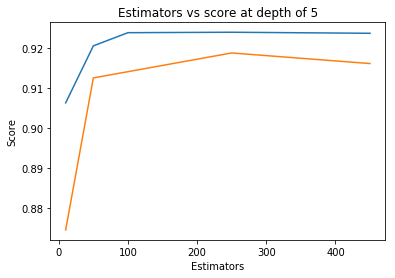

In [0]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8916120853581238 test Score 0.8687934859875491
depth =  9 Train Score 0.9572226298198419 test Score 0.9222953031452904
depth =  11 Train Score 0.9623451340902863 test Score 0.9252318758281279
depth =  15 Train Score 0.9634267621927706 test Score 0.9231288356496615
depth =  20 Train Score 0.9631629153051491 test Score 0.9235051024711141
depth =  35 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  50 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  70 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  130 Train Score 0.9634333127085721 test Score 0.9235601652753184


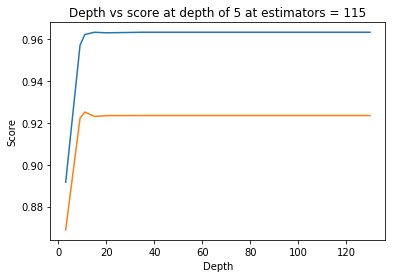

In [0]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [0]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier()

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',verbose = 30, n_jobs=-1)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

In [0]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [0]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [0]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652533106548414
Test f1 score 0.9241678239279553


In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
#     cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


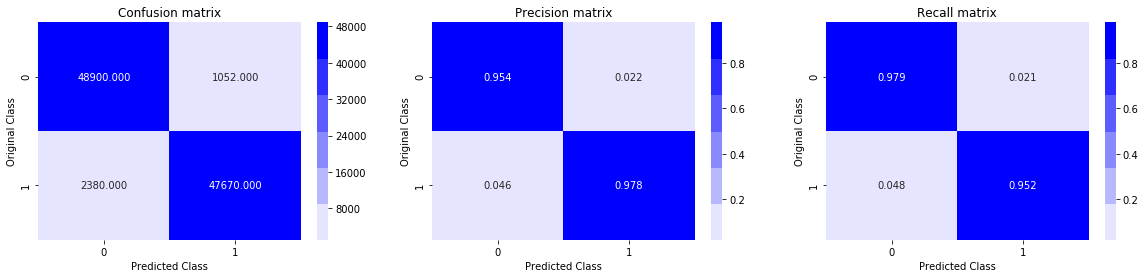

Test confusion_matrix


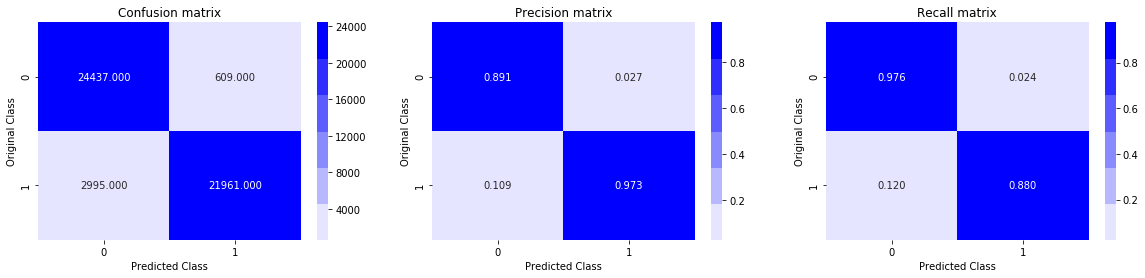

In [0]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

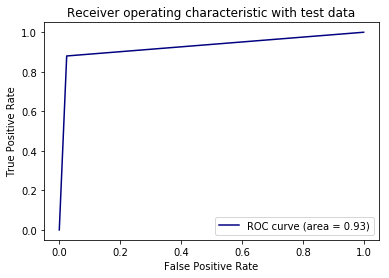

In [0]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

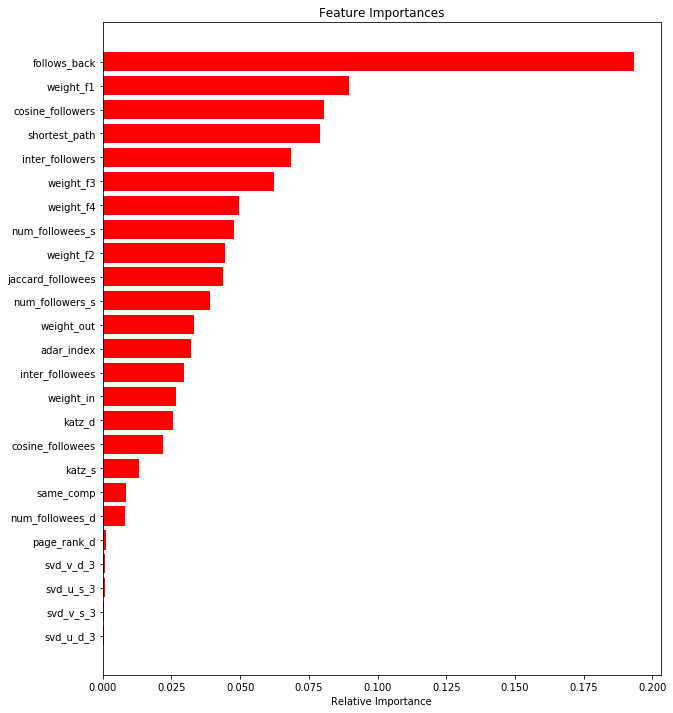

In [0]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- - - 

# Applying XGBOOST Classifier


In [0]:
import xgboost as xgb

In [18]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV


params = {"n_estimators":[5,10,20,35,50,75,100,150],
              "max_depth": [2,5,10,15,25]}

clf = xgb.XGBClassifier()

xg_grid = GridSearchCV(clf, param_grid=params, scoring='f1', verbose = 1, return_train_score=True, n_jobs=-1)

xg_grid.fit(df_final_train,y_train)

train_error = xg_grid.cv_results_['mean_train_score']
cv_error = xg_grid.cv_results_['mean_test_score']

print('mean test scores',cv_error)
print('mean train scores',train_error)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarnin

mean test scores [0.9093935  0.91520883 0.91944168 0.9260257  0.94300771 0.95832148
 0.96438198 0.97150018 0.92818631 0.9301223  0.96118415 0.96817463
 0.97193336 0.97373327 0.97526257 0.97765709 0.97265926 0.97331634
 0.97473276 0.97598237 0.97656874 0.97802458 0.97908447 0.98060856
 0.97285756 0.97413794 0.97535537 0.97646277 0.97732781 0.97848266
 0.9791213  0.97974681 0.97267874 0.97407814 0.97555716 0.97657357
 0.97720709 0.97817292 0.97873396 0.97938576]
mean train scores [0.91019882 0.91563653 0.91996065 0.92644195 0.94388957 0.95896703
 0.9649739  0.97185908 0.9283499  0.93014524 0.96154266 0.9683186
 0.97245427 0.97462561 0.9768479  0.98118547 0.97717446 0.97834334
 0.98039857 0.98240957 0.98350513 0.9869836  0.99225097 0.9987748
 0.9883703  0.99030902 0.99390048 0.9966334  0.99778277 0.99919519
 0.99994505 1.         0.99313963 0.99586417 0.99859558 0.99972532
 0.99991509 0.99998502 1.         1.        ]


In [19]:
print(xg_grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [0]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

### Error Plots

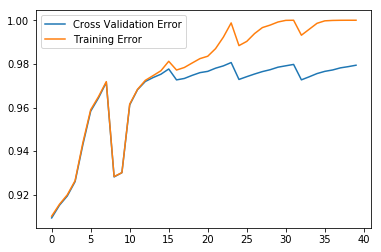

In [22]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9971163666219436
Test f1 score 0.9257393116057572


Train confusion_matrix


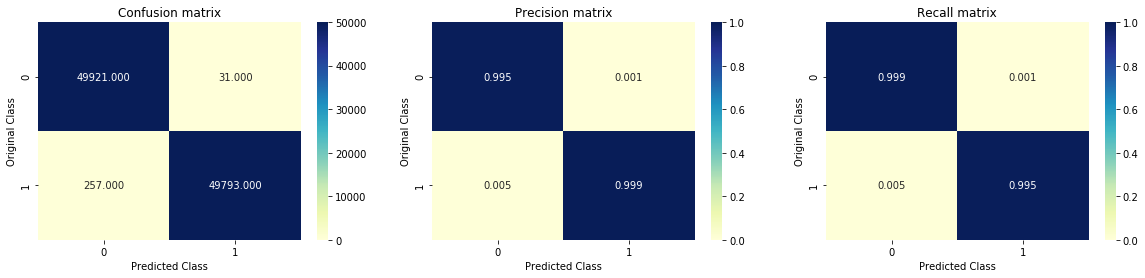

Test confusion_matrix


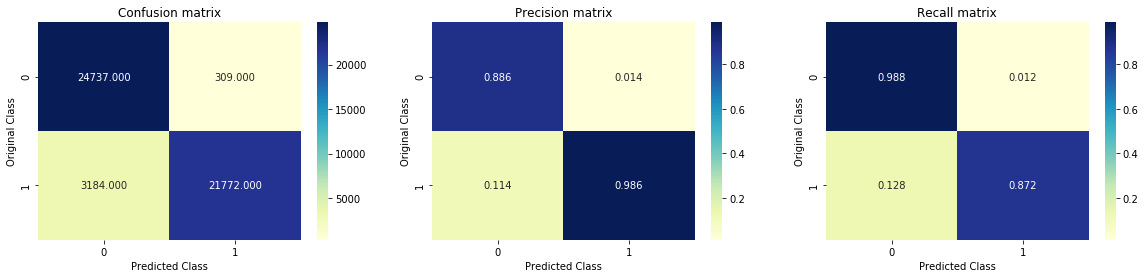

In [24]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

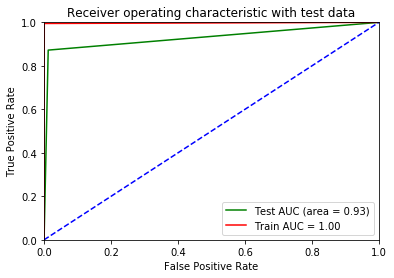

In [25]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
fpr2,tpr2,ths = roc_curve(y_train,y_train_pred)

auc_sc = auc(fpr, tpr)
auc_sc_train = auc(fpr2, tpr2)

plt.plot(fpr, tpr, color='green',label='Test AUC (area = %0.2f)' % auc_sc)
plt.plot(fpr2, tpr2, 'red', label = 'Train AUC = %0.2f' % auc_sc_train)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

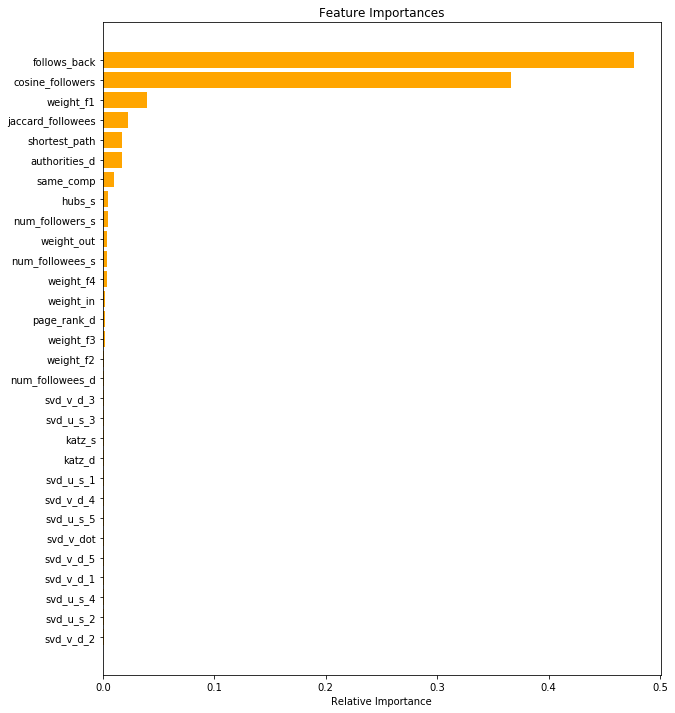

In [28]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- Clearly the features 'follows back' and 'cosine followers' are the most important among all others.

- - -

# Conclusions:


In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Algorithm", "Train AUC", "Test AUC"]

x.add_row(["Random Forest", 0.97, 0.93])
x.add_row(["XGBoost", 1.0, 0.93 ])


print(x)

+---------------+-----------+----------+
|   Algorithm   | Train AUC | Test AUC |
+---------------+-----------+----------+
| Random Forest |    0.97   |   0.93   |
|    XGBoost    |    1.0    |   0.93   |
+---------------+-----------+----------+
